# Datatrack.py Tutorial
Datatracks are the bread and butter of a great deal of research computational biology. After much of the preprocessing of experimental sequencing data we are usually left with a file which in some way details how some measurement of interest varies across the genome. The simplest way of thinking about a datatrack is just as a function which can take real values. If we let $\mathbf{C}$ be the set of chromosomes then we might define a datatrack as a function:


\begin{equation}
    f: \mathbb{N}_{+}\times\mathbf{C} \to \mathbb{R}
\end{equation}

Where we input a positive integer and chromosome and we get a real value. This value could, for example, tell us about the strength of binding of a given protein to a given basepair. Or it could be the number of reads which we observe at that basepair.

### The DataTrack Class
Simple and quick manipulation of the functions which we come across for various ChIPseq datasets (or, for example, DNA methylation dataset datasets) vastly increases the speed at which different hypotheses can be tested. Being able to keep track of variables also greatly reduces mental load! The Datatrack class is a quick way to load up data from standard data sources and interrogate them to find out properties of the underlying functions which they represent. 

### dtrack_utils
The Datatrack class makes heavy use of a cython module called GrapHiC.utils.dtrack_utils. Mastering this module will allow users to implement much more complicated things than in this notebook. However, the datatrack class is useful as-is for a lot of analysis. It's been implemented in cython so that many of the most common tasks such as overlapping two datatracks or collecting statistics on some group of regions can be done faster than would be possible in python.


## Importing Modules

In [22]:
#dtrack_utils Cython Module
#from GrapHiC.utils import dtrack_utils as dtu
#Numpy is always useful for numerical manipulation
import numpy as np
import itertools
import pandas as pd
#Import our datatrack classes!
from GrapHiC.utils.Datatrack import DataTrack_rvp as dtrvp
from GrapHiC.utils.Datatrack import DataTrack_bigwig as dtbw

from GrapHiC.Datatrack_creation import evaluate_tracks_over_cooler_bins, evaluate_tracks_over_bed_dataframe

# Basic Datatrack creation over cooler bins

One of the basic things to do with datatracks is to collect statistics for those tracks over hi-C data for each bin. We can do this using the evaluate_tracks_over_cooler_bins function:

In [23]:
contact_path = 'tutorial_data/WT_contacts.cool'
nanog_peaks = "tutorial_data/GSEXXXXXHendrich20161026_Nanog_ESC_peaks.bed"
nanog_bigwig = "tutorial_data/GSE71932_Nanog_mESCs_treat_pileup_filter.bw"

In [24]:
df = evaluate_tracks_over_cooler_bins(contact_path,
                             paths = [nanog_peaks,nanog_bigwig],
                             names = ['nanog_bigwig','nanog_peaks'],
                             stats_types = ['mean','max','std'],
                             allowed_chroms = ['chr1','chr2','chrX'],
                                      value_col = 4
                            )
df

nanog_bigwig tutorial_data/GSEXXXXXHendrich20161026_Nanog_ESC_peaks.bed
	mean
	max
	std
nanog_peaks tutorial_data/GSE71932_Nanog_mESCs_treat_pileup_filter.bw
	mean
	max
	std


,nanog_bigwig_mean,nanog_bigwig_max,nanog_bigwig_std,nanog_peaks_mean,nanog_peaks_max,nanog_peaks_std
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
26346,0.0,0.0,0.0,0.0,0.0,0.0
26347,0.0,0.0,0.0,0.10049,6.0,0.586188
26348,0.0,0.0,0.0,0.092287,6.0,0.501517
26349,0.0,0.0,0.0,0.147928,3.0,0.489231


## Evaluation over arbitrary regions
alternatively, we can evaluate datatracks over arbitrary regions specificed by a bed file. Let's take a look at some regions of active promoters:

In [25]:
df = pd.read_table("tutorial_data/active_promoters.csv")

colnames, arr = evaluate_tracks_over_bed_dataframe(df,
                             paths = [nanog_peaks,nanog_bigwig],
                             names = ['nanog_bigwig','nanog_peaks'],
                             stats_types = ['mean','max','std'],
                             value_col = 4
                            )
pd.DataFrame(data = arr, columns = colnames)

nanog_bigwig tutorial_data/GSEXXXXXHendrich20161026_Nanog_ESC_peaks.bed
	mean
	max
	std
nanog_peaks tutorial_data/GSE71932_Nanog_mESCs_treat_pileup_filter.bw
	mean
	max
	std


,nanog_bigwig_mean,nanog_bigwig_max,nanog_bigwig_std,nanog_peaks_mean,nanog_peaks_max,nanog_peaks_std
0,0.00000,0.0,0.000000,7.225386,37.0,7.559524
1,0.00000,0.0,0.000000,4.174326,13.0,2.608505
2,0.00000,0.0,0.000000,3.006454,9.0,1.850368
3,0.00000,0.0,0.000000,3.074620,8.0,1.882457
4,7.74675,99.0,26.587894,4.073532,16.0,3.523583
...,...,...,...,...,...,...
10208,0.00000,0.0,0.000000,2.200084,6.0,1.574169
10209,0.00000,0.0,0.000000,1.917015,8.0,1.600306
10210,0.00000,0.0,0.000000,2.287324,18.0,2.841367
10211,0.00000,0.0,0.000000,1.609052,5.0,1.164586


# Region-Value Pair Datatracks
## BED format files
One of the most common formats for storing datatracks is in region-value-pair format. That is, on each chromosome we simple detail the regions where the function $f$ takes nonzero values and we specify the value that the function takes in that region. Below is an example of bed file created for a Nanog ChIPseq from naive embryonic stem cells:

In [27]:
!head tutorial_data/GSEXXXXXHendrich20161026_Nanog_ESC_peaks.bed

chr1	3062626	3063246	GSEXXXXXHendrich20161026_Nanog_ESC_peak_1	1091
chr1	3445421	3446366	GSEXXXXXHendrich20161026_Nanog_ESC_peak_2	658
chr1	3681365	3681811	GSEXXXXXHendrich20161026_Nanog_ESC_peak_3	48
chr1	3947036	3947306	GSEXXXXXHendrich20161026_Nanog_ESC_peak_4	55
chr1	4150783	4151277	GSEXXXXXHendrich20161026_Nanog_ESC_peak_5	1017
chr1	4447859	4448346	GSEXXXXXHendrich20161026_Nanog_ESC_peak_6	329
chr1	4611937	4612228	GSEXXXXXHendrich20161026_Nanog_ESC_peak_7	104
chr1	4660171	4660590	GSEXXXXXHendrich20161026_Nanog_ESC_peak_8	195
chr1	4802495	4802928	GSEXXXXXHendrich20161026_Nanog_ESC_peak_9	424
chr1	4819456	4819933	GSEXXXXXHendrich20161026_Nanog_ESC_peak_10	346


We can see that there is chromosome information in collumn zero, then a region start collumn, a region end collumn, some unique IDs for each peak and then a value collumn detailing the size of the function at each peak. Lets go ahead and load this information into a DataTrack_rvp object (the rvp stands for region-value-pairs) using the .from_bed() method:

In [28]:
#In order to initialise our Datatrack all we need to do is specify a name. So lets create datatrack object
#with name nanog and save it in the variable nanog
nanog = dtrvp("Nanog")

#Lets now construct the datatrack from the bed file
nanog.from_bed(nanog_peaks,
               chrom_col = 0, #What collumn is our chromosome information in?
               region_cols = (1,2), #What collumns are our region start and region end?
               value_col = 4, #What collumns are our values in?
               ID_col = 3) #What collumns are our region IDs in?)

Note that we could also ignore the ID and value information and simply put all values as a constant:

In [29]:
nanog = dtrvp("Nanog").from_bed(nanog_peaks,
                                chrom_col = 0, #What collumn is our chromosome information in?
                                region_cols = (1,2), #What collumns are our region start and region end?
                                value_col = None, #What collumns are our values in?
                                value_fill = 1,
                                ID_col = None)

Now we can take a look at the data which is in our datatrack object:

In [30]:
#Lets take a look at our regions first
nanog.regions['chr1']

array([[  3062626,   3063246],
       [  3445421,   3446366],
       [  3681365,   3681811],
       ...,
       [194354695, 194354978],
       [194472371, 194472801],
       [194890314, 194890780]], dtype=int32)

In [31]:
#Now our values in chromosome 2
nanog.values['chr2']

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [32]:
#We can also look at the name and type of our datatrack if we forget
print("'nanog' is a datatrack of type: {}".format(nanog.dtrack_type))
print("It has name: {}".format(nanog.name))

'nanog' is a datatrack of type: region-value-pairs
It has name: Nanog


## Interrogating the datatrack function
Lets now look at functions for investigating region-value-pair functions. 

### Chromosome Limits
One of the first things we might be interested in is what the lengths of our chromosomes actually are! The Datatrack class doesn't assume that the chromosomes have any particular length and leaves these as functions which are free to be input by the user. However, we can estimate the chromosome limits from the maximum and minimum values of the regions we observe on each chromosome:

In [33]:
nanog.chrlims_from_regions()
nanog.chr_lims

{'chr1': [3062626, 194890780],
 'chr10': [3302560, 130420449],
 'chr11': [3145328, 121964594],
 'chr12': [3124034, 119777974],
 'chr13': [3712816, 119334473],
 'chr14': [7809188, 124446400],
 'chr15': [3748080, 103383326],
 'chr16': [3531957, 97936334],
 'chr17': [3505534, 94866952],
 'chr18': [3006850, 90581368],
 'chr19': [3532657, 61321440],
 'chr2': [3100032, 181773870],
 'chr3': [3370820, 159615381],
 'chr4': [3368156, 156194661],
 'chr5': [3293540, 151645339],
 'chr6': [4118617, 149357512],
 'chr7': [3507008, 145139802],
 'chr8': [3100430, 128538866],
 'chr9': [3376306, 123731738],
 'chrX': [6279324, 169906459],
 'chrY': [4829304, 4829578]}

### Datatrack function evaluation

Now that we have estimated our chromosome limits let's look at interrogating our function. Looking at the function for all values in a given region is simple and just uses the .func method. We just provide a midpoint and a windowsize (or buffer) around that midpoint where we want to evaluate the function:

In [34]:
#Here is the start of a peak in our Nanog datatrack on chromosome 1
nanog.func('1',[3062586], buffer = 100)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

Note that we can provide multiple midpoints and we'll get multiple rows in our output array:

In [35]:
#Here is the start of a peak in our Nanog datatrack on chromosome 1
nanog.func('1',[3062686,194354695], buffer = 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

This comes in use when we might want to evaluate a function across an entire set of genomic regions. For example active promoters:

In [36]:
x = pd.read_table('tutorial_data/active_promoters.csv')
x = {k1: np.concatenate([item[None,1:3] for item in list(g1)],
                                       axis = 0).astype('int32') for k1,g1 in itertools.groupby(sorted(x.values,
                                                                                                       key = lambda x:x[0]),
                                                                                                lambda x: x[0])}
x['chr1']

array([[ 57993971,  57997971],
       [ 11412112,  11416112],
       [136129183, 136133183],
       [ 91296338,  91300338],
       [ 43443751,  43447751],
       [193033698, 193037698],
       [ 91364430,  91368430],
       [ 75140786,  75144786],
       [ 64120282,  64124282],
       [151258914, 151262914],
       [ 75208778,  75212778],
       [181838568, 181842568],
       [ 52117438,  52121438],
       [155081266, 155085266],
       [152764351, 152768351],
       [161967186, 161971186],
       [ 63174825,  63178825],
       [166000960, 166004960],
       [ 86524736,  86528736],
       [ 52628705,  52632705],
       [ 53295018,  53299018],
       [ 88006551,  88010551],
       [156717001, 156721001],
       [ 45793166,  45797166],
       [ 72581251,  72585251],
       [178403881, 178407881],
       [ 80338480,  80342480],
       [166378493, 166382493],
       [131960967, 131964967],
       [152764542, 152768542],
       [177794511, 177798511],
       [163401641, 163405641],
       [

These are the active promoter regions on chromosome 1 in naive ES cells. Lets look at nanog signal within +/-1kb of the active promoter centres on chromosome 1:

In [37]:
buffer = 1000
promoter_nanog_signal = np.zeros(2*buffer)
numproms = 0
for chrom in nanog.chromosomes:
    try:
        mids = np.mean(x[chrom], axis = 1).astype('int')
    except:
        print("couldn't find active promoter info for chromosome {}".format(chrom))
        continue
        
    promoter_nanog_signal += np.sum(nanog.func(chrom, mids, buffer = buffer), axis = 0)
    numproms += len(mids)

promoter_nanog_signal /= numproms

couldn't find active promoter info for chromosome chrY


Text(0.5, 1.0, 'Active promoter nanog signal\nNaive mESCs')

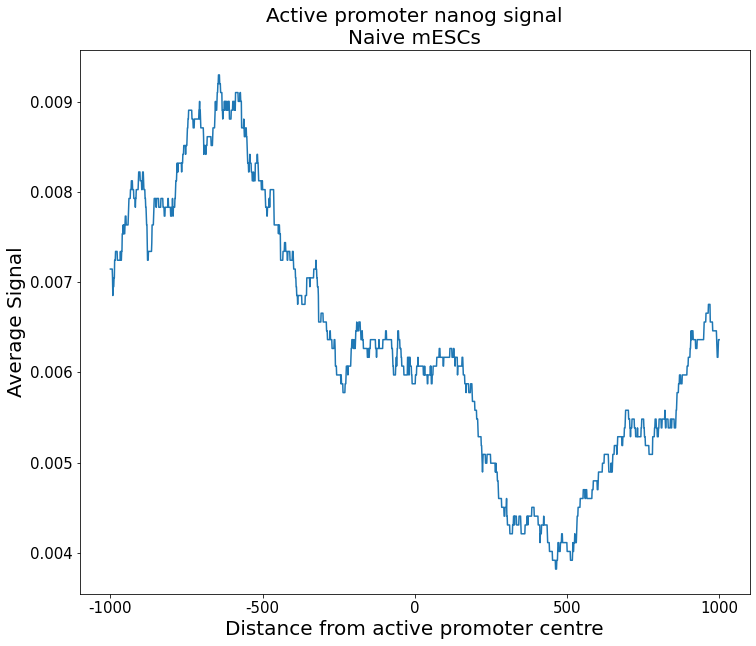

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,10))
plot = plt.plot(np.arange(len(promoter_nanog_signal)), promoter_nanog_signal)
xticks = plt.xticks([0,500,1000,1500,2000], [-1000, -500, 0, 500,1000])
plt.tick_params(labelsize = 15)
plt.ylabel("Average Signal", size = 20)
plt.xlabel("Distance from active promoter centre", size = 20)
plt.title("Active promoter nanog signal\nNaive mESCs", size = 20)

We might also just be interested in looking at coverage over certain regions. We can therefore replace the datatrack values with constants if we want to when evaluating the function:

couldn't find active promoter info for chromosome chrY


Text(0.5, 1.0, 'Chromosome 1 active promoter nanog signal\nNaive mESCs')

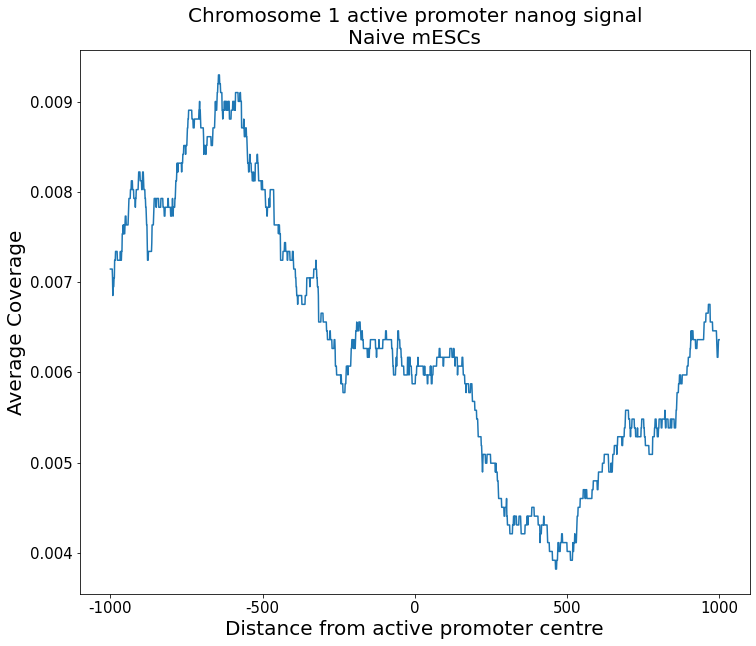

In [39]:
buffer = 1000
promoter_nanog_signal = np.zeros(2*buffer)
numproms = 0
for chrom in nanog.chromosomes:
    try:
        mids = np.mean(x[chrom], axis = 1).astype('int')
    except:
        print("couldn't find active promoter info for chromosome {}".format(chrom))
        continue
        
    promoter_nanog_signal += np.sum(nanog.func(chrom, mids, buffer = buffer, use_constant_val = 1), axis = 0)
    numproms += len(mids)

promoter_nanog_signal /= numproms
fig = plt.figure(figsize = (12,10))
plot = plt.plot(np.arange(len(promoter_nanog_signal)), promoter_nanog_signal)
xticks = plt.xticks([0,500,1000,1500,2000], [-1000, -500, 0, 500,1000])
plt.tick_params(labelsize = 15)
plt.ylabel("Average Coverage", size = 20)
plt.xlabel("Distance from active promoter centre", size = 20)
plt.title("Chromosome 1 active promoter nanog signal\nNaive mESCs", size = 20)

### Raw data within an interval 
We might instead want to get the actual raw region-value-pair information which overlaps with a region:

In [40]:
nanog.data_in_interval('chr1', [3062586, 3062686])

{'regions': array([[3062626, 3063246]], dtype=int32), 'values': array([[1.]])}

### Binning Data within an interval
One more thing we might like to do is bin all of our information within a given region. For example, we might want to bin the entirety of chromosome 19 at a bin-size of 1000000 basepairs per bin and we're interested in the average Nanog signal per basepair in each bin:

#### mean per-basepair signal

In [41]:
nanog.bin_single_interval('chr19',
                          int(1e6),
                          interval = nanog.chr_lims['chr19'],
                          stats_type = 'mean')[1]

array([0.00303 , 0.006552, 0.001425, 0.000669, 0.00132 , 0.00296 ,
       0.002537, 0.003173, 0.001201, 0.002482, 0.001221, 0.00664 ,
       0.002168, 0.00283 , 0.000415, 0.004411, 0.000977, 0.001374,
       0.003797, 0.007565, 0.007639, 0.00335 , 0.001578, 0.002382,
       0.007922, 0.005926, 0.003652, 0.001017, 0.002473, 0.003697,
       0.00318 , 0.004725, 0.002021, 0.002326, 0.008272, 0.001042,
       0.004696, 0.003917, 0.004359, 0.002566, 0.003806, 0.002973,
       0.00468 , 0.003173, 0.001299, 0.001785, 0.001107, 0.001866,
       0.000896, 0.003227, 0.001479, 0.003052, 0.00401 , 0.003168,
       0.003457, 0.002755, 0.004034, 0.001409])

We could also look at the coverage (in basepairs) within each bin:

#### Coverage

In [42]:
nanog.bin_single_interval('chr19',
                          int(1e6),
                          interval = nanog.chr_lims['chr19'],
                          stats_type = 'coverage')[1]

array([3030., 6552., 1425.,  669., 1320., 2960., 2537., 3173., 1201.,
       2482., 1221., 6640., 2168., 2830.,  415., 4411.,  977., 1374.,
       3797., 7565., 7639., 3350., 1578., 2382., 7922., 5926., 3652.,
       1017., 2473., 3697., 3180., 4725., 2021., 2326., 8272., 1042.,
       4696., 3917., 4359., 2566., 3806., 2973., 4680., 3173., 1299.,
       1785., 1107., 1866.,  896., 3227., 1479., 3052., 4010., 3168.,
       3457., 2755., 4034., 1409.])

We may also be interested in the mean signal within basepairs where we observe any signal at all:

#### Mean per-region signal

In [43]:
nanog.bin_single_interval('chr19',
                          int(1e6),
                          interval = nanog.chr_lims['chr19'],
                          stats_type = 'per_region_mean')[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

Finally we might be interested in the sum of all basepair signals in our data over each bin
#### Sum of all signals

In [44]:
nanog.bin_single_interval('chr19',
                          int(1e6),
                          interval = nanog.chr_lims['chr19'],
                          stats_type = 'sum')[1]

array([3030., 6552., 1425.,  669., 1320., 2960., 2537., 3173., 1201.,
       2482., 1221., 6640., 2168., 2830.,  415., 4411.,  977., 1374.,
       3797., 7565., 7639., 3350., 1578., 2382., 7922., 5926., 3652.,
       1017., 2473., 3697., 3180., 4725., 2021., 2326., 8272., 1042.,
       4696., 3917., 4359., 2566., 3806., 2973., 4680., 3173., 1299.,
       1785., 1107., 1866.,  896., 3227., 1479., 3052., 4010., 3168.,
       3457., 2755., 4034., 1409.])

## Statistics over an interval
We can also just input random intervals and get statistics across these intervals. Here we can use the stats function to pass an interval as well as a statistic of interest (stats_type) for regions within this interval. As with the func method we can also access multiple intervals at once:

### Coverage

In [45]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'coverage')

array([25946., 38367.])

### Maximum value

In [46]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'max')

array([1., 1.])

### Minimum value

In [47]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'min')

array([0., 0.])

### Minimum value in regions with coverage

In [48]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'per_region_min')

array([1., 1.])

### Standard deviation of values

In [49]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'std')

array([0.05087109, 0.06182216])

### Standard deviation of values in regions with coverage

In [50]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'per_region_std')

array([0., 0.])

### Mean value

In [51]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'mean')

array([0.0025946, 0.0038367])

### Mean value in regions with coverage

In [52]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'per_region_mean')

array([1., 1.])

### Sum of all values

In [53]:
nanog.stats('chr1', [[0,1e7],[1e7,2e7]], stats_type= 'sum')

array([25946., 38367.])

# BigWig files

BigWig data isn't actually included in the tutorial data since it is a

In [54]:
nanog = dtbw("Nanog").from_bw(nanog_bigwig)

In [55]:
nanog.chr_lims

{'chr1': [0, 195471971],
 'chr3': [0, 160039680],
 'chr2': [0, 182113224],
 'chr4': [0, 156508116],
 'chr7': [0, 145441459],
 'chr6': [0, 149736546],
 'chr9': [0, 124595110],
 'chr5': [0, 151834684],
 'chr11': [0, 122082543],
 'chr12': [0, 120129022],
 'chr8': [0, 129401213],
 'chrY': [0, 91744698],
 'chrX': [0, 171031299],
 'chr10': [0, 130694993],
 'chr13': [0, 120421639],
 'chr15': [0, 104043685],
 'chr14': [0, 124902244],
 'chr16': [0, 98207768],
 'chr19': [0, 61431566],
 'chr18': [0, 90702639],
 'chr17': [0, 94987271]}

In [56]:
nanog.header

{'version': 4,
 'nLevels': 10,
 'nBasesCovered': 2722424231,
 'minVal': 0,
 'maxVal': 410,
 'sumData': 6747542629,
 'sumSquared': 99418129997}

In [57]:
#Here is the start of a peak in our Nanog datatrack on chromosome 1
nanog.func('chr1',[3062586], buffer = 100)

array([[ 5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
         8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
         8.,  8.,  7.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
         9.,  9.,  9., 10., 10., 10., 10.,  9.,  9.,  9.,  9.,  9.,  9.,
         9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 10., 11., 11.,
        11., 11., 11., 11., 11., 12., 12., 12., 12., 13., 13., 12., 12.,
        12., 12., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 14.,
        14., 14., 14., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
        15., 15., 15., 15., 15., 15., 15., 15., 15.

Lets reload our promoter info and see if we can form similar plots as above when we used the BED files:

In [59]:
buffer = 1000
promoter_nanog_signal = np.zeros(200)
numproms = 0
for chrom in nanog.chromosomes:
    print(chrom)
    try:
        mids = np.mean(x[chrom], axis = 1).astype('int')
    except:
        print("couldn't find active promoter info for chromosome {}".format(chrom))
        continue
        
    promoter_nanog_signal += np.sum(nanog.func(chrom, mids, buffer = buffer, binSize = 10), axis = 0)
    numproms += len(mids)

promoter_nanog_signal /= numproms

chr1
chr3
chr2
chr4
chr7
chr6
chr9
chr5
chr11
chr12
chr8
chrY
couldn't find active promoter info for chromosome chrY
chrX
chr10
chr13
chr15
chr14
chr16
chr19
chr18
chr17


Text(0.5, 1.0, 'Active promoter nanog signal\nNaive mESCs')

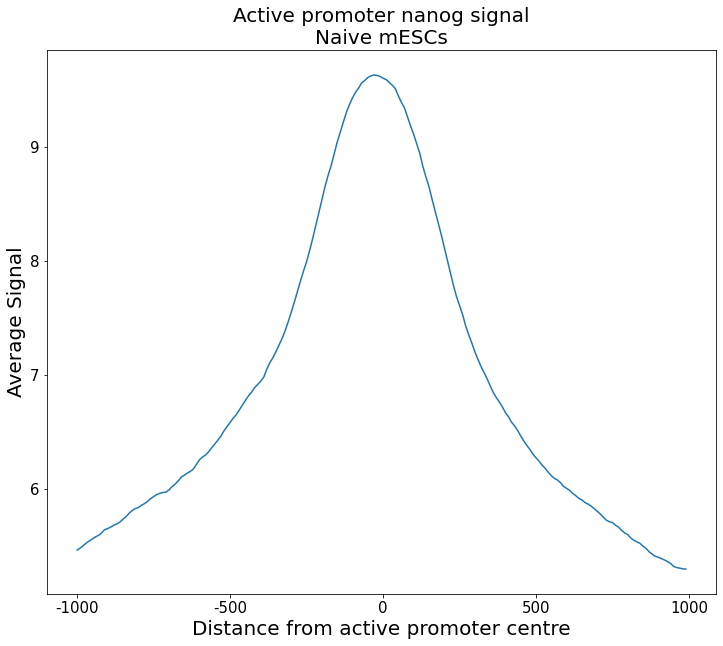

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,10))
plot = plt.plot(np.arange(len(promoter_nanog_signal)), promoter_nanog_signal)
xticks = plt.xticks([0,50,100,150,200], [-1000, -500, 0, 500,1000])
plt.tick_params(labelsize = 15)
plt.ylabel("Average Signal", size = 20)
plt.xlabel("Distance from active promoter centre", size = 20)
plt.title("Active promoter nanog signal\nNaive mESCs", size = 20)